# Rasterization
We want to burn a bounding box into a raster to delimit an area of interest within an image. 

In [1]:
import os
import numpy as np
import math
from osgeo import gdal, osr, ogr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
print("NumPy version: %s"%np.__version__)
print("GDAL version: %s"%gdal.__version__)

NumPy version: 1.23.1
GDAL version: 3.5.1


We use a subset image that was exctracted from a Landsat 9 image over Southern Italy. The subset image covers ann area in the Italian province of Latina with two towns: Gaeta and Formia.  

In [12]:
path = 'data/raster/Landsat/Italy/'
patch_fn = os.path.join(path, 'patch.tif')

Image format: TIFF
Shape (rows, cols): (667, 667)
Mode: I;16


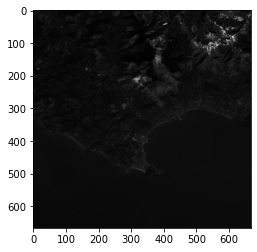

In [13]:
patch_band = Image.open(patch_fn)
print('Image format: {}\nShape (rows, cols): {}\nMode: {}'.format(patch_band.format, patch_band.size, patch_band.mode))
plt.imshow(patch_band, cmap='gray')

In [14]:
patch_ds = gdal.Open(patch_fn)
rows = patch_ds.RasterXSize
cols = patch_ds.RasterYSize
print('Rows: {0}\nColumns: {1}'.format(rows, cols))

Rows: 667
Columns: 667


We need to know which coordinate reference system (CRS) is used in the image, the coordinates of its origin, the pixel size (resolution), and the lenght of the area in horizontal and vertical direction. We will use the same CRS also for the polygon. We can see that the CRS is the projected Universal Transverse Mercator (UTM) [EPSG:32633](https://epsg.io/32633)

In [15]:
patch_ds.GetProjection()

'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]'

In [16]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = patch_ds.GetGeoTransform()
print('x origin: {} m.\ny origin: {} m.\nx pixel res.: {} m.\ny pixel res: {} m.'.format(x_origin, 
                                                                                         y_origin, 
                                                                                         x_pixel_resolution, 
                                                                                         y_pixel_resolution))

x origin: 369885.0 m.
y origin: 4577715.0 m.
x pixel res.: 30.0 m.
y pixel res: -30.0 m.


In [17]:
x_size = rows * x_pixel_resolution
y_size = cols * x_pixel_resolution
print('X size: {:0.1f} Km\nY size: {:0.1f} Km'.format(x_size / 1000, y_size / 1000))

X size: 20.0 Km
Y size: 20.0 Km


We want to superimpose a bounding box over the image, with the origin translated 5 Km to east and 5 Km to the south with respect to the origin of the image, to limit our area of interest over Gaeta.  

In [18]:
x_t = 7000 # space shift of the polygon origin from the image origin in meters
y_t = -11000
delta_x = 5000 # subset east shift
delta_y = -5000 # subset south shift
x_nw = x_origin + x_t # x coordinate of the subset origin NW
y_nw = y_origin + y_t # y coordinate of the subset origin NW
print('NW (x, y): ({}, {})\n'.format(x_nw, y_nw))
x_se = x_nw + delta_x # x coordinate of the subset origin SE
y_se = y_nw + delta_y # x coordinate of the subset origin SE
print('SE (x, y): ({}, {})\n'.format(x_se, y_se))

NW (x, y): (376885.0, 4566715.0)

SE (x, y): (381885.0, 4561715.0)



We build the bounding box by creating a linear ring from the four vertices: north-west, south-west, south-east, and north-east. 

In [21]:
from shapely.geometry import Point
bbox = ogr.Geometry(ogr.wkbLinearRing)
bbox.AddPoint(x_nw, y_nw)
bbox.AddPoint(x_nw, y_se) # south-west
bbox.AddPoint(x_se, y_se)
bbox.AddPoint(x_se, y_nw) # north-east
bbox.AddPoint(x_nw, y_nw)
print(bbox.ExportToWkt())

LINEARRING (376885 4566715 0,376885 4561715 0,381885 4561715 0,381885 4566715 0,376885 4566715 0)


We create a new vector data file to store the bounding box.

In [20]:
import sys
json_driver = ogr.GetDriverByName('GeoJSON')
json_fn = os.path.join(path,'bounding_box.json')
if os.path.exists(json_fn):
    layer = None
    json_ds = None
    json_driver.DeleteDataSource(json_fn)
json_ds = json_driver.CreateDataSource(json_fn)
srs = ogr.osr.SpatialReference()
srs.ImportFromEPSG(32633)

if json_ds is None:
    sys.exit('Could not create {0}.'.format(json_fn))

bbox_layer = json_ds.CreateLayer('bounding box', srs, ogr.wkbLinearRing)
bbox_def = bbox_layer.GetLayerDefn()
bbox_feat = ogr.Feature(bbox_def)
bbox_feat.SetGeometry(bbox)
bbox_layer.CreateFeature(bbox_feat)

del bbox_feat
del bbox_layer
del json_ds 